# Remote Sensing – Introduction to Using Machine Learning for Satellite Data

In this notebook, we will delve into the fundamentals of machine learning (ML) applied to satellite data.

We will focus on a dataset called *Pavia University*, which is an example of *hyperspectral imagery* (HSI). Our objective is to perform *hyperspectral segmentation*, a task that involves classifying each pixel in a satellite photo into distinct categories such as trees, meadows, asphalt, and more. The Pavia University dataset provides *ground truth (GT) labels* created by the dataset's authors. By leveraging the input image data and labels, we will develop a machine learning model using *supervised learning*, a technique where the algorithm is trained with input-output pairs. The result of our demo will be a model capable of detecting multiple classes across the Pavia University area.

The level of Python and machine learning expertise of the reader may determine the extent of interest in this notebook. It can serve as an engaging demonstration of ML concepts or as an introduction to applying statistical analysis to satellite hyperspectral data. As this demo is concise, please feel free to explore additional sources and literature to gain a deeper understanding of these topics.

> 💬 **NOTICE**: Certain parts of this notebook are interactive and may not function until you run this file on your computer within a Jupyter environment.

We'll start by importing the necessary Python libraries and setting some options up. We will use `numpy`, `scipy`, and `einops` for data manipulation, `matplotlib` for visualization, `scikit-image` for image manipulation, and finally `scikit-learn` for machine learning.

In [1]:
import numpy as np
import scipy
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from ipywidgets import interact
from skimage.exposure import equalize_adapthist
from sklearn.model_selection import train_test_split
from sklearn import svm, ensemble, metrics, preprocessing, multiclass
from einops import rearrange

In [2]:
%config InlineBackend.figure_format='retina'  # Better image display quality

We will define a variable to serve as a seed for random generator states, which can be used later. Setting random state seeds during experiments ensures deterministic execution.

In [3]:
RANDOM_STATE = 42

## Loading data

In this notebook, we will use the Pavia University dataset.

The data is taken from [Kaggle](https://www.kaggle.com/datasets/syamkakarla/pavia-university-hsi).

Pavia University is a small dataset often used as an introductory task in remote sensing. It was captured by the *Reflective Optics System Imaging Spectrometer (ROSIS)* sensor and features a pixel size of 1.3 meters with 103 spectral bands covering wavelengths ranging from 0.43 to 0.86 μm (a scientific [overview](https://www.researchgate.net/publication/344099034_Performance_Analysis_of_Advanced_Decision_Forest_Algorithms_in_Hyperspectral_Image_Classification) of Pavia University and some other rudimentary remote sensing datasets).

Although the dataset and methods employed in this notebook are relatively simple, modern state-of-the-art solutions are much more complex. However, Pavia University serves as a gentle entry point to the topics discussed.

We will start with loading the data (from Matlab format) using scipy.

In [4]:
PAVIA_WAVELENGTHS_RANGE_NM = (0.43, 0.86)

In [5]:
dataset = scipy.io.loadmat('./PaviaU.mat')
dataset.keys()

dict_keys(['__header__', '__version__', '__globals__', 'paviaU'])

There are some metadata fields in this file, however, we are mainly interested in the data itself.

In [6]:
pavia_cube = dataset['paviaU']
pavia_cube.dtype, pavia_cube.shape

(dtype('<u2'), (610, 340, 103))

We have loaded a hyperspectral cube in the format of two-byte-unsigned-interger-pixels with spatial dimensions of 610 by 340 and 103 channels. The vast number of channels is why we call the data hyperspectral cube. Instead of having three of them – red, green, and blue – the cube features over 100 channels.

Alongside the hyperspectral image, we also load some *ground truth (GT)* labels. Each pixel in the dataset has an annotated class (although some are labeled as empty).

In [7]:
dataset_labels = scipy.io.loadmat('./PaviaU_gt.mat')
dataset_labels.keys()

dict_keys(['__header__', '__version__', '__globals__', 'paviaU_gt'])

In [8]:
labels = dataset_labels['paviaU_gt']
labels.dtype, labels.shape

(dtype('uint8'), (610, 340))

The cube and labels have the same spatial dimensions which is expected. Now, after the data is loaded we can start data exploration.

## Hyperspectral cube exploration

Let's start with calculating some basic statistics for our data.

In [9]:
print(f'''
{pavia_cube.min()=},
{pavia_cube.max()=},
{pavia_cube.mean()=},
{pavia_cube.std()=},
{pavia_cube.dtype=},
''')


pavia_cube.min()=0,
pavia_cube.max()=8000,
pavia_cube.mean()=1389.1253099399873,
pavia_cube.std()=897.6575399774091,
pavia_cube.dtype=dtype('<u2'),



The data is stored as two-byte-unsiged-integers, we will have to deal with this later. We should also notice that the data doesn't fill the whole data type range ($ 2^{16} > 8000 $).

### Previewing image channels

We can now see the actual image, we can grab the first channel among the 103 ones and display it.

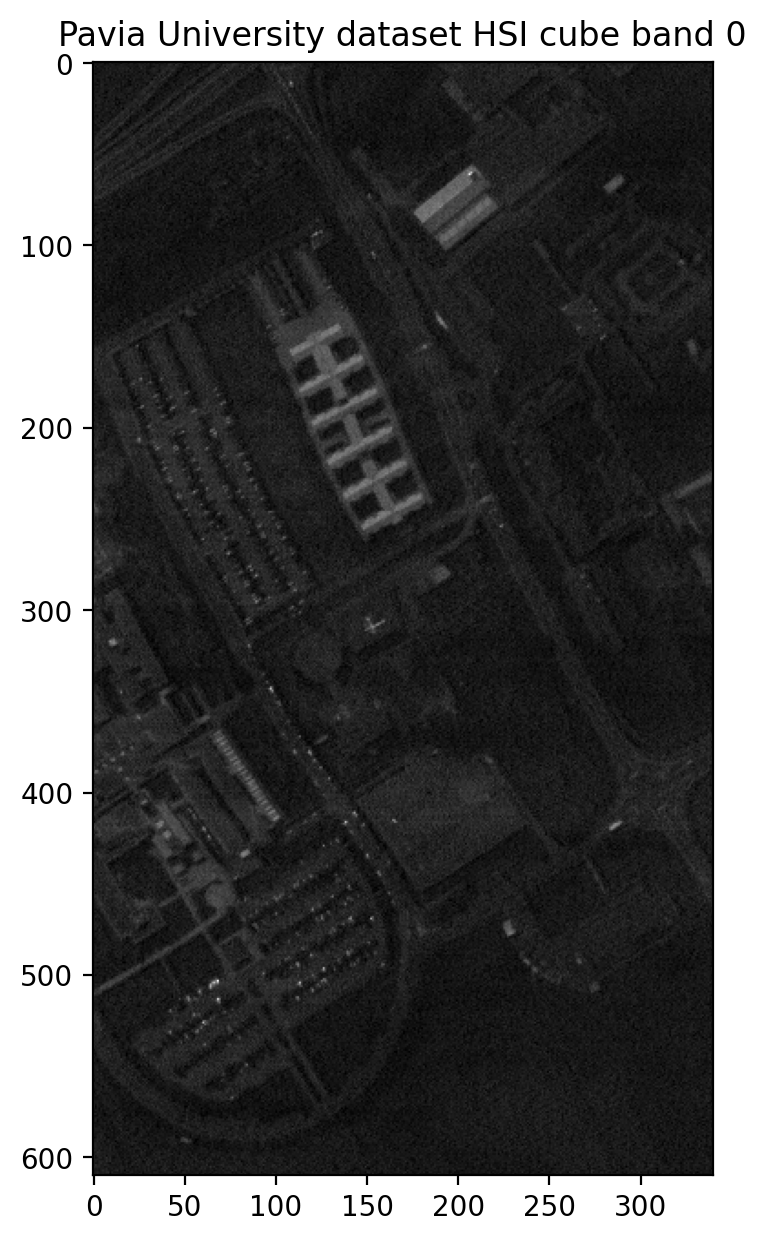

In [10]:
preview_channel_idx = 0
plt.figure(figsize=(4, 8))
plt.imshow(pavia_cube[..., preview_channel_idx], cmap='gray')
plt.title(f'Pavia University dataset HSI cube band {preview_channel_idx}')
plt.show()

We have over a hundred channels more, we can preview them using the interactive features of Jupyter Notebooks. Execute the cell below and move the slider to investigate what different channels look like.

In [11]:
num_channels = pavia_cube.shape[-1]

@interact(channel_idx=(0, num_channels - 1))
def preview_channel(channel_idx: int = 0):
    plt.figure(figsize=(4, 8))
    plt.imshow(pavia_cube[..., channel_idx])
    plt.title(f'Pavia University dataset HSI cube band {channel_idx}')

interactive(children=(IntSlider(value=0, description='channel_idx', max=102), Output()), _dom_classes=('widget…

We can also use channels that correspond to red, blue, and green light wavelengths and compose them into an RGB image.

In [12]:
PAVIA_RGB_IDXS = (50, 30, 15)

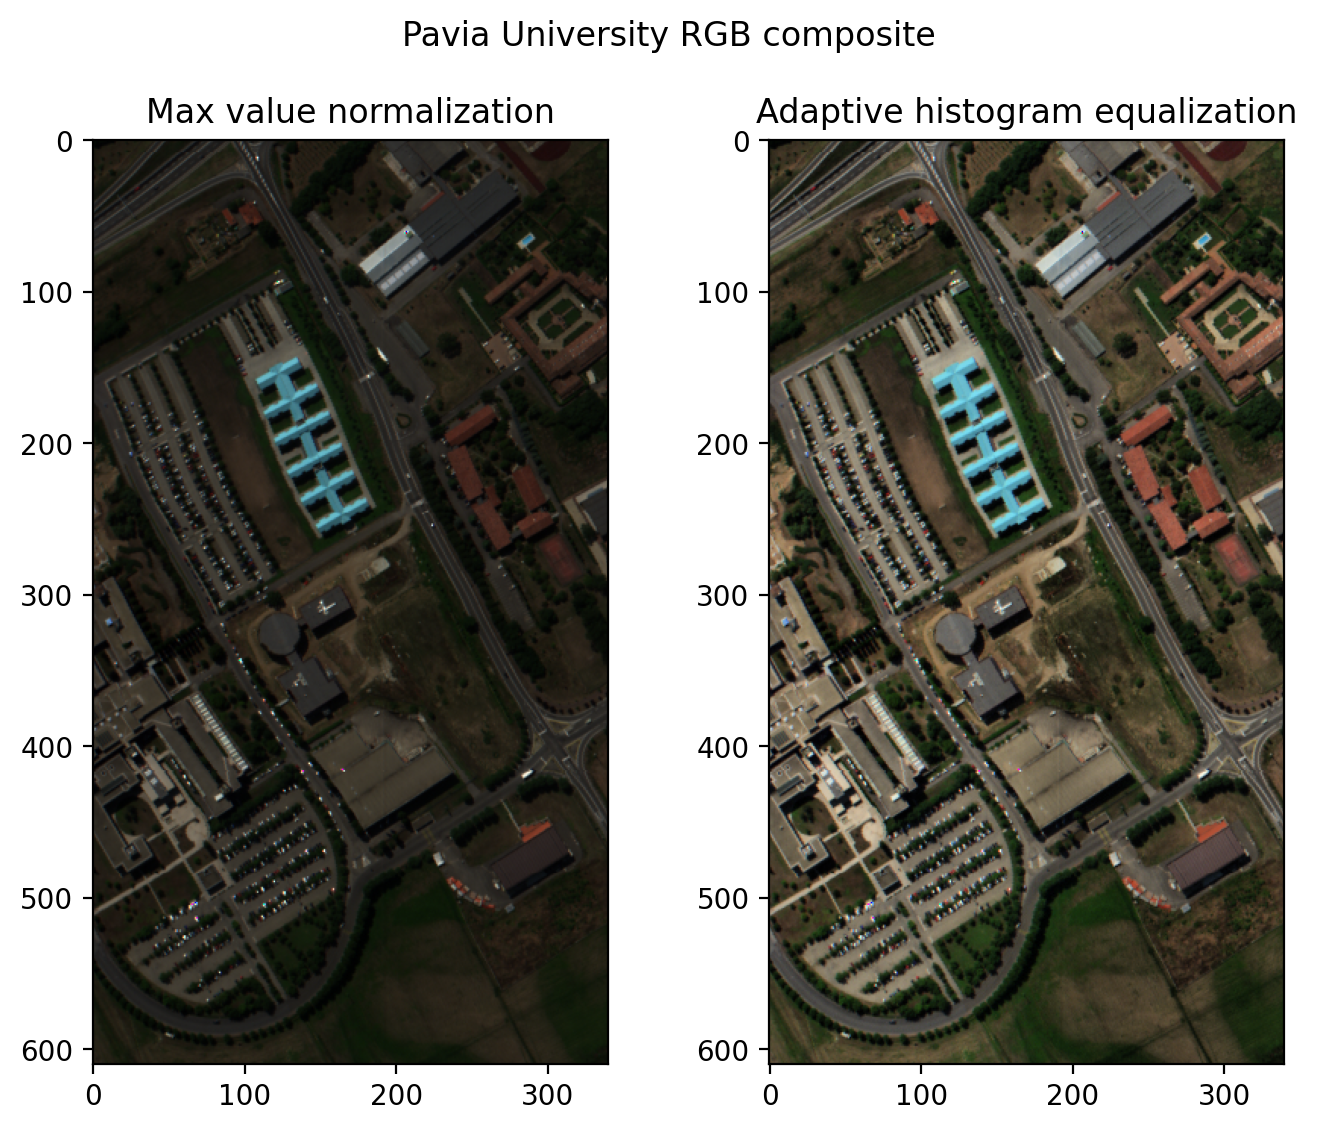

In [13]:
pavia_rgb = pavia_cube[..., PAVIA_RGB_IDXS]
pavia_rgb = pavia_rgb / pavia_rgb.max()

plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.title('Max value normalization')
plt.imshow(pavia_rgb)
plt.subplot(1, 2, 2)
plt.title('Adaptive histogram equalization')
plt.imshow(equalize_adapthist(pavia_rgb))


plt.suptitle('Pavia University RGB composite')
plt.show()

pavia_preview = equalize_adapthist(pavia_rgb)

Since the original image is the big dark and lacks contrast, for visualization purposes, we can apply histogram equalization to it, to make the image better looking. We can see several buildings, parking lots, and some greenery in the picture. We'll save the preview image for later visualizations.

### Spectral signatures and channel properties

Now, let's take a closer look at the spectral properties of the image. For each of the 103 channels, we will calculate the mean brightness and plot it. We will also use the predefined spectral range of the cube, to plot the same mean brightness values against channel frequencies.

In [14]:
mean_per_channel = pavia_cube.mean(axis=(0, 1))
channel_frequencies = np.linspace(PAVIA_WAVELENGTHS_RANGE_NM[0], PAVIA_WAVELENGTHS_RANGE_NM[1], num_channels)

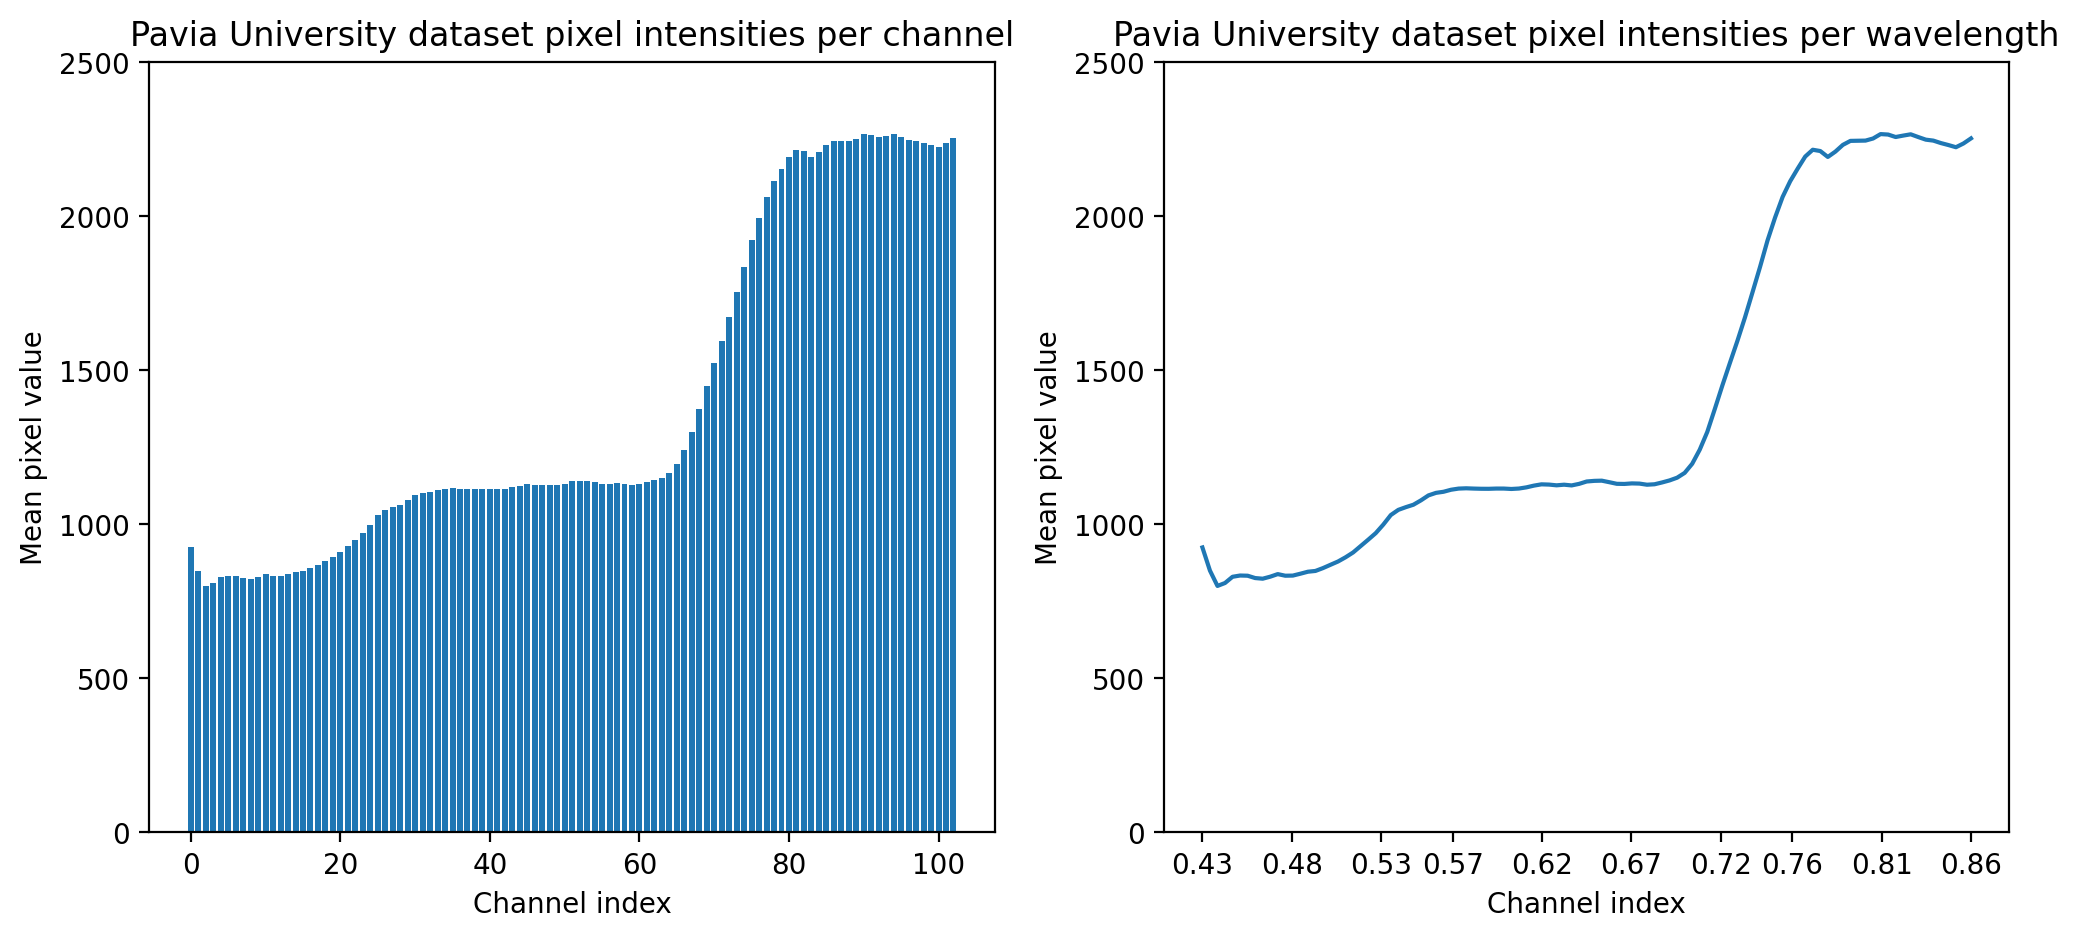

In [15]:
mean_per_channel = pavia_cube.mean(axis=(0, 1))
channel_frequencies = np.linspace(PAVIA_WAVELENGTHS_RANGE_NM[0], PAVIA_WAVELENGTHS_RANGE_NM[1], num_channels)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(range(0, num_channels), mean_per_channel)
plt.xlabel('Channel index')
plt.ylabel('Mean pixel value')
plt.title('Pavia University dataset pixel intensities per channel')
plt.ylim(0, 2500)

plt.subplot(1, 2, 2)
plt.plot(channel_frequencies, mean_per_channel)
plt.xlabel('Channel index')
plt.ylabel('Mean pixel value')
plt.title('Pavia University dataset pixel intensities per wavelength')
plt.ylim(0, 2500)
plt.xticks(np.round(np.linspace(PAVIA_WAVELENGTHS_RANGE_NM[0], PAVIA_WAVELENGTHS_RANGE_NM[1], num_channels//10), 2))

plt.show()

We can see that the later channels are overall brighter.

A small caveat about channel values. Take a look at where vegetation can be found in the image (lush grass areas and trees), go back to the interactive image with the channels slider, and look at what happens when you choose a bigger index (longer wavelength). The foliage areas become very bright, this is because plants reflect a lot of infrared parts of the light spectrum. To say colloquially, vegetation *glows* in near-infrared light. This property is very useful in remote sensing and supervision of crop growth.

Now, let's check the histograms of specific channels. It would be rather hard to preview histograms for all 103 channels comfortably, however, we can preview every tenth of them.

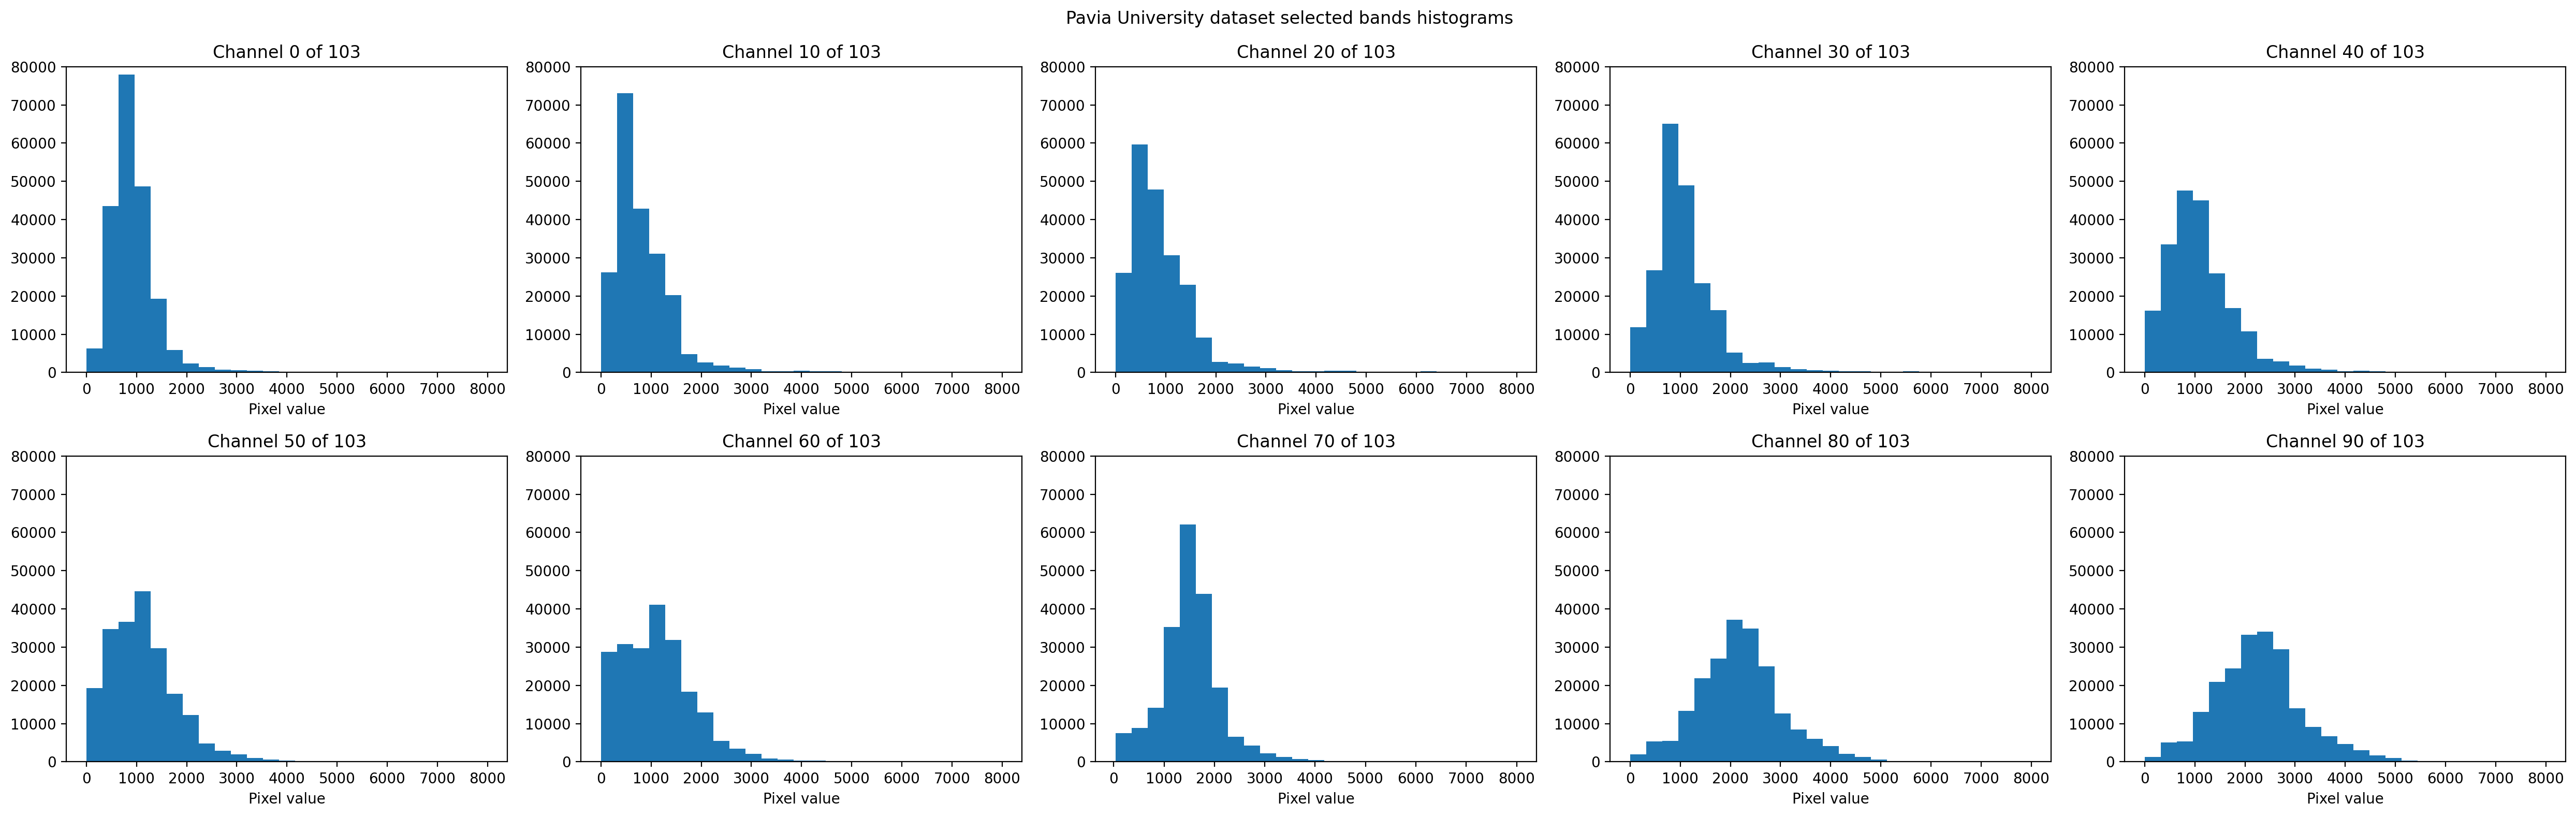

In [16]:
plt.figure(figsize=(25, 8))

for i in range(num_channels // 10):
    plt.subplot(2, 5, i + 1)
    plt.hist(pavia_cube[..., i * 10].flatten(), bins=25)
    plt.title(f'Channel {i * 10} of {num_channels}')
    plt.ylim(0, 80_000)
    plt.xlabel('Pixel value')

plt.suptitle('Pavia University dataset selected bands histograms')
plt.tight_layout()
plt.show()

Again, the latter channels are brighter. The histograms resemble a bit skewed normal curves. Once again, we can use the interactive features and preview arbitrary channels with sliders.

In [17]:
@interact(channel_idx=(0, num_channels - 1))
def plot_channel(channel_idx: int = 0):
    plt.hist(pavia_cube[..., channel_idx].flatten(), bins=25)
    plt.title(f'Channel {channel_idx} of {num_channels}')
    plt.ylim(0, 80_000)
    plt.xlabel('Pixel value')
    plt.ylabel('Count')


interactive(children=(IntSlider(value=0, description='channel_idx', max=102), Output()), _dom_classes=('widget…

We have taken a look at the Pavia University hyperspectral image, now let's have a peek at the data labels.

## GT labels analysis

In machine learning classes of obejcts are denoted as numbers (identifiers). From our Kaggle source we know what the consective numeric label encode. Let's define the label names in our code.

In [18]:
LABEL_NAMES = ('Empty', 'Asphalt', 'Meadows', 'Gravel', 'Trees', 'Metal sheet', 'Bare soil', 'Bitumen', 'Brick', 'Shadow')
LABEL_NAMES_VALID = LABEL_NAMES[1:]

In [19]:
labels.shape, np.unique(labels)

((610, 340), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8))

We have nine unique classes with an extra one denoting unlabelled pixels. Now, let's count how many pixels of each of the classes we have in the image.

In [20]:
np.bincount(labels.flatten())

array([164624,   6631,  18649,   2099,   3064,   1345,   5029,   1330,
         3682,    947])

There is a substantial difference in how many pixels belong to each of the classes. This is called an *imbalanced* dataset. We can take a close look by making another histogram.

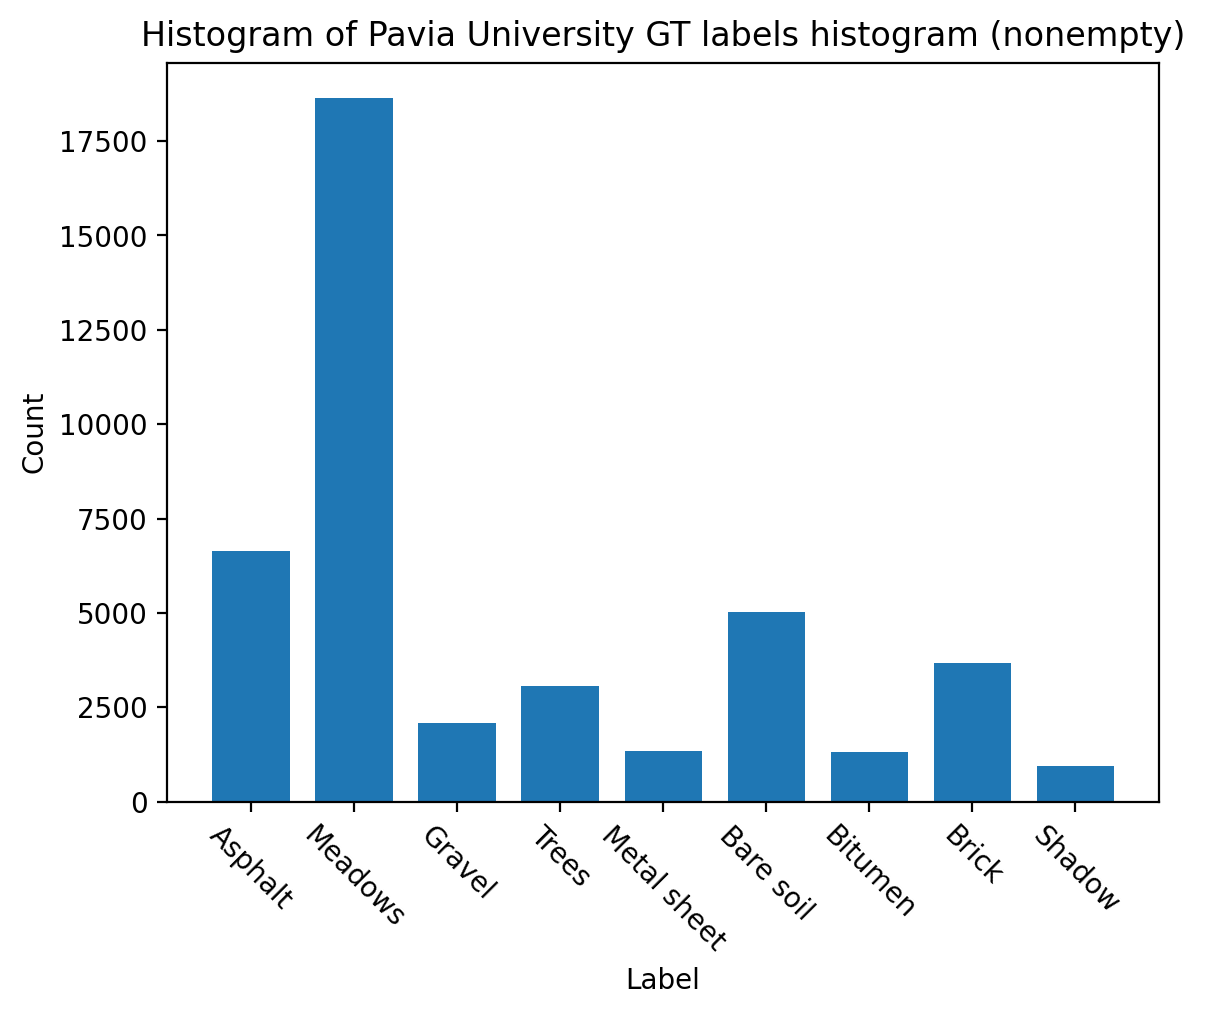

In [21]:
labels_valid_flat = labels[labels != 0]
bin_centers = np.arange(1, 1 + np.unique(labels_valid_flat).size)  # We start from 1 to omit empty class
bins = np.arange(1, 1 + np.unique(labels_valid_flat).size + 1) - 0.5  # We start from 1 to omit empty class

plt.hist(labels_valid_flat, bins=bins, rwidth=0.75)
plt.xticks(bin_centers, labels=LABEL_NAMES_VALID, rotation=-45)
plt.title('Histogram of Pavia University GT labels histogram (nonempty)')
plt.ylabel('Count')
plt.xlabel('Label')
plt.show()

### Previewing the classes

We can compare a map of class annotations with the RGB image preview to gain a better understanding of our dataset.

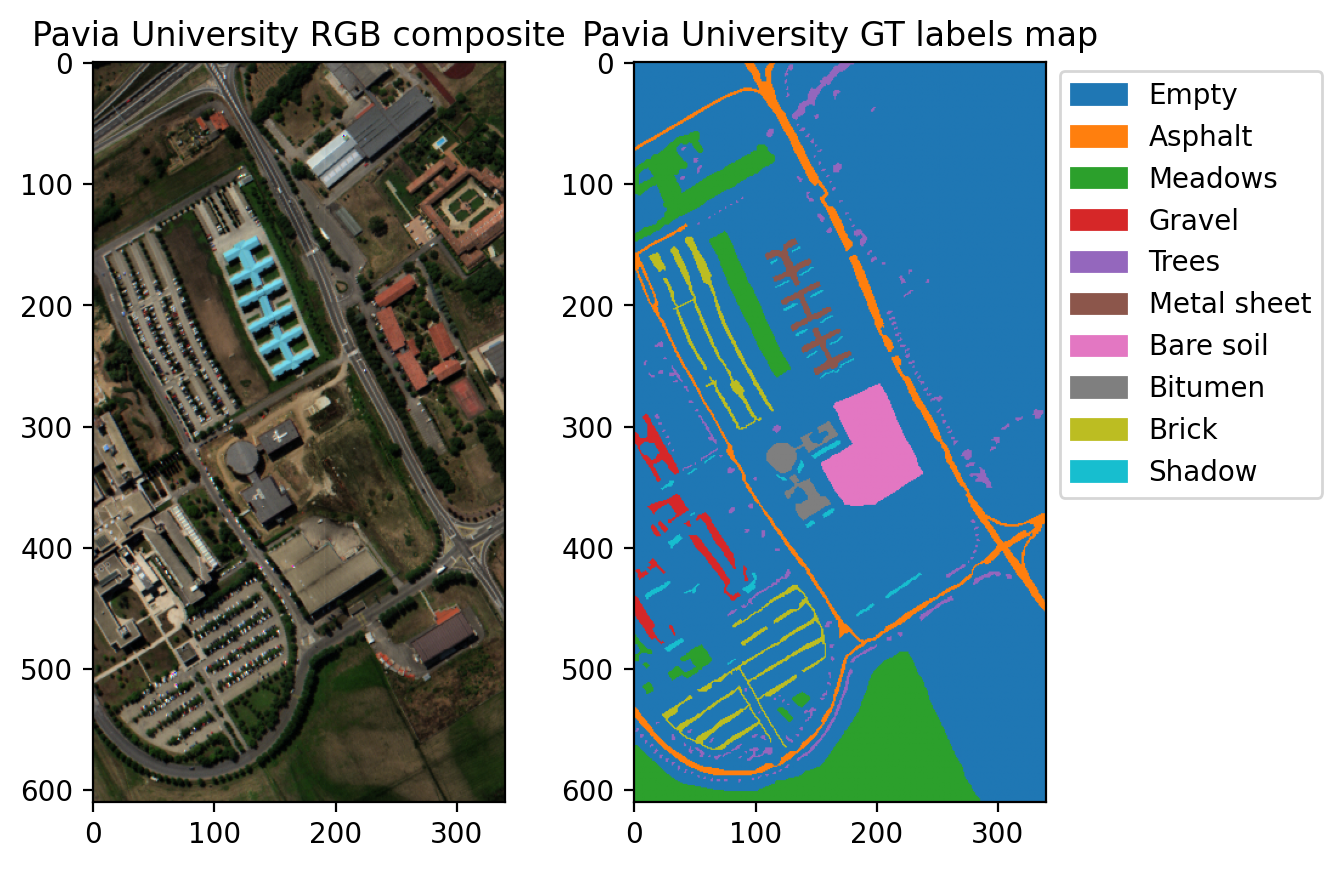

In [22]:
plt.subplot(1, 2, 1)
plt.title('Pavia University RGB composite')
plt.imshow(pavia_preview)

plt.subplot(1, 2, 2)
cmap = plt.get_cmap('tab10')
plt.title('Pavia University GT labels map')
plt.imshow(cmap(labels))

color_patches = [mpatches.Patch(color=cmap(i), label=LABEL_NAMES[i]) for i in range(len(LABEL_NAMES))]
plt.legend(color_patches, LABEL_NAMES, loc='center left', bbox_to_anchor=(1, 0.7))

plt.show()

The preview confirms that most of the pixels in the image belong to the unlabelled class, thus the dataset is imbalanced.

We can visualize classes by making an image overlay too.

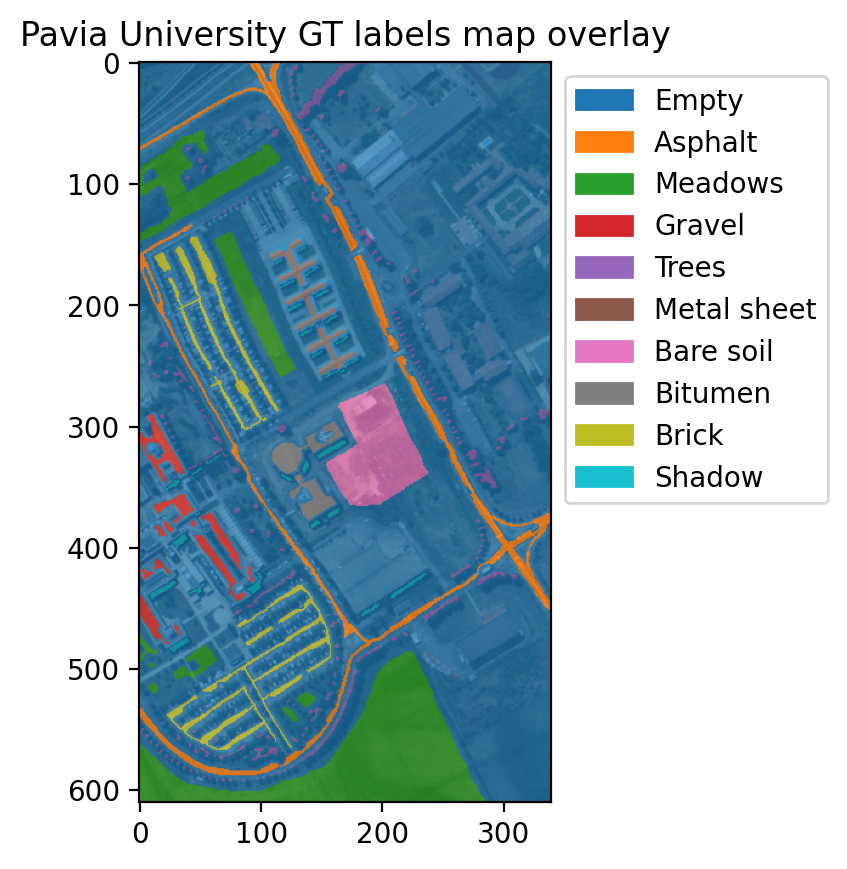

In [23]:
cmap = plt.get_cmap('tab10')
plt.imshow(0.3 * pavia_preview + 0.75 * cmap(labels)[..., :-1])

color_patches = [mpatches.Patch(color=cmap(i), label=LABEL_NAMES[i]) for i in range(len(LABEL_NAMES))]
plt.legend(color_patches, LABEL_NAMES, loc='upper left', bbox_to_anchor=(1, 1))

plt.title('Pavia University GT labels map overlay')
plt.show()

## Dataset preparation

We have investigated the data a bit, and now let's prepare it for training a machine learning model that will learn to automatically classify pixels to one among the 9 classes (we will discard the empty one).

Let's start by grabbing only the pixels that have a valid label assigned.

In [24]:
pavia_valid_pixels = pavia_cube[labels != 0]
pavia_valid_pixels.size / pavia_cube.size

0.20624879459980713

Only 20% of all pixels have labels, however, we will still be able to make sense of them with a simple ML model.

Now we have to create a split into train and test subsets. It is crucial to train machine learning models on one set of data and evaluate it against another one, that has not taken part in the training. Only in this way, we can investigate whether the model is able to reason well beyond what has been presented to it during the training process. The model's ability to work with previously unseen data (perhaps *in the wild*) is called *generalization capabilities*. Generalization is a serious concern if we want our models to be useful in real-life situations and applications. If the model works well on the train data, but poorly on the previously unseen test samples, then it is subject to *overfitting*.


We will discuss generalization a bit later again.

For now, we have to remember to split the data into train and test sets and be cautious not to use test data in the training process. If we use test samples in training, we make a mistake called *test data leak*. Beware it, as it does harm our ability to access the generalization capabilities of the model.

We will reach out with the help of scikit-learn and its ability to automatically split data. We also use a parameter for *stratification* which is important when working with imbalanced datasets like ours. If we split randomly an imbalanced dataset there is a that the less populous class would be misrepresented in one of the splits. Stratification ensures that each of the splits has the same distribution of labels among the classes.

In [25]:
x_train, x_test, y_train, y_test = train_test_split(pavia_valid_pixels, labels_valid_flat, test_size=0.3, stratify=labels_valid_flat, random_state=RANDOM_STATE)
print(f'''
{x_train.shape=},
{y_train.shape=},
{x_test.shape=},
{y_test.shape=},
''')


x_train.shape=(29943, 103),
y_train.shape=(29943,),
x_test.shape=(12833, 103),
y_test.shape=(12833,),



Notice that we used random state seed to make the process reproducible.

Before we move futher, let's evaluate whether stratification worked correctly.

In [26]:
np.bincount(y_train.flatten()) / y_train.size, np.bincount(y_test.flatten()) / y_test.size

(array([0.        , 0.15502789, 0.43596166, 0.04905988, 0.07163611,
        0.03145977, 0.11755669, 0.03109241, 0.08606352, 0.02214207]),
 array([0.        , 0.15499104, 0.43598535, 0.04909218, 0.07161225,
        0.03140341, 0.11758747, 0.03109172, 0.08610613, 0.02213044]))

Seems it did. Now we can perform more analysis on the training subset. It is important to avoid running too many analyses on the test data, as it can indirectly cause data leaks via design.

### Input data in-depth analysis

We can investigate a bit further the relation between spectral signatures of pixels and classes in the training subset. For each of the classes, we will plot the mean spectral curve.

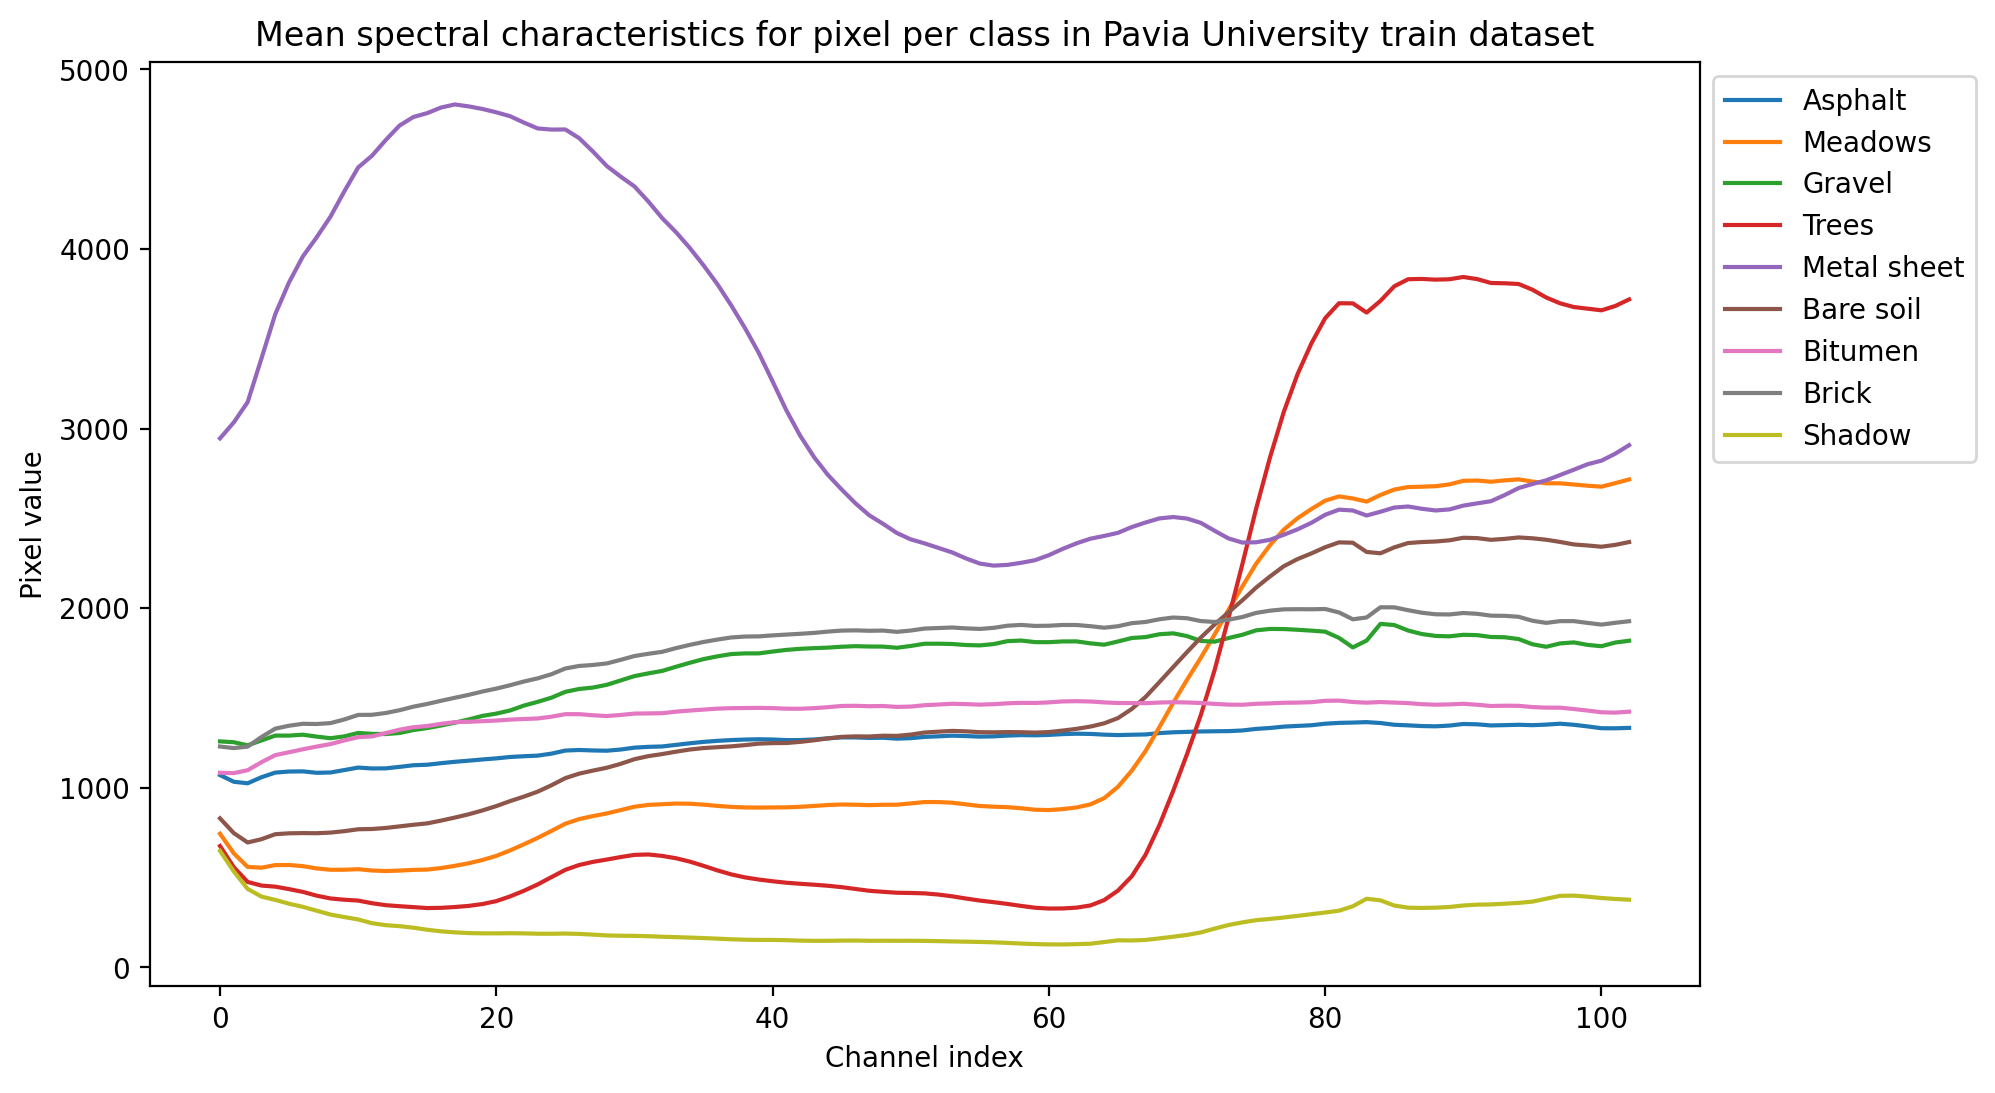

In [27]:
plt.figure(figsize=(10, 6))
for label in np.unique(y_train):
    xs_in_class = x_train[y_train == label]
    mean_spectrum_in_class = xs_in_class.mean(axis=0)
    plt.plot(mean_spectrum_in_class)
plt.legend(LABEL_NAMES_VALID, loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Channel index')
plt.ylabel('Pixel value')
plt.title('Mean spectral characteristics for pixel per class in Pavia University train dataset')
plt.show()

The spectral signatures are what the model is going to use to distinguish different classes. We have to double-check if the actually look separable and specific to each class. So they seem, some classes are a bit similar (e.g. bitumen and asphalt), but overall this looks promising. We can move on to the next part of the process.

## Data preprocessing and normalization

### Input samples

Machine learning models require specific input formats in order to work. The data has to be *normalized* to fit into a well defined input range. This usually is in the range of 0 to 1. Our data ranges from 0 to around 8000, we can fix this by using min-max scaling. This simple process could be done manually, however, there is a function for that in scikit-learn.

In [28]:
scaler = preprocessing.MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_train_scaled.min(), x_train_scaled.max()

scaler.data_min_, scaler.data_max_

(array([  0.,   0.,   0.,   0.,   0.,   0.,  39.,  63.,  62.,  12.,  12.,
         27.,  36.,   0.,   0.,   2.,  11.,  20.,   2.,   0.,   0.,   7.,
          0.,   0.,  13.,   0.,   0.,   0.,   8.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   1.,   0.,   0.,   4.,   9.,   7.,  17.,   6.,   5.,  15.,
          7.,  11.,  16.,   5.,   1.,   0.,   0.,   0.,   0.,  10.,  27.,
         25.,  20.,  35.,  29.,  37.,  60.,  70.,  92., 102.,  99.,  80.,
         90.,  79.,  76.,  90., 101., 113., 174., 161., 126., 102.,  91.,
        101., 124., 141., 143., 136., 141., 126., 152., 164., 204., 177.,
        140., 135., 138., 153.]),
 array([4595., 4994., 5436., 5999., 6526., 6824., 7158., 7342., 7470.,
        7773., 8000., 8000., 8000., 8000., 8000., 8000., 8000., 8000.,
        8000., 8000., 8000., 8000., 8000., 8000., 8000., 8000., 8000.,
        8000., 8000., 8000., 8000., 8000., 8000., 8000., 8000., 8000.,
        8000., 8

Many of the preprocessors and models in the library follow the convention of class instantiation (perhaps with some parameters) and calling `fit` on a dataset. Later the fitted model can be used to transform data with the `transform` operation. These two can often be combined into one `fit_transform`, as in our case where we calculate min-max values from the training set and apply the normalization to it in one line.

We can also peak the min and max values used for normalization per channel (global normalization is an option too if you will).

### Ground truth labels

The labels have to be preprocessed too. Let's remind ourselves of how do they look like.

In [29]:
y_train.shape, np.unique(y_train)

((29943,), array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8))

Notice that the default encoding implies a relation of order between them (this is called *ordinal* encoding). Labels 6 and 7 are close to each other and labels 2 and 8 are not. This has no ground in the real-world and there is no ordinance between materials like gravel and trees. This form of encoding may unfortunately suggest such a relation to the model. We will encode the labels into a different form called *one-hot encoding* which saves the labels as sparse vectors/matrices where 1 on a given index indicates a class. In this encoding, the indices, not the values, represent the classes.

Whereas on-hot encoding is more reasonable for data without ordinality (such as ours) some algorithms may yield better results for different encodings (even though they may seem less reasonable). Experimenting with different encoding techniques may be a part of the process of fine-tuning our solution.

We can, once again, use scikit-learn for that with `fit_transform`. We have to expand our array to transform it into a sparse matrix.

In [30]:
encoder = preprocessing.LabelBinarizer()
y_train_encoded = encoder.fit_transform(y_train)
y_train_encoded.shape

(29943, 9)

Let's peek into the results.

In [31]:
print(y_train[0])
print(y_train_encoded[0])

6
[0 0 0 0 0 1 0 0 0]


In [32]:
print(y_train[2])
print(y_train_encoded[2])

4
[0 0 0 1 0 0 0 0 0]


The sample that previously was labeled with class 6 now has 1.0 at index 5 ($ 6 - 1 $ because valid classes start from 1 and one hot encoding indexes from 0). Similarly, for a class with identifier 4, we get a 1 at index 3.

### Adjusting the test set

We cannot use the test set for setting preprocessing properties, but once we establish the processing pipeline it has to be applied to the test data to in order to work.

In [33]:
x_test_scaled = scaler.transform(x_test)
y_test_encoded = encoder.transform(y_test.reshape(-1, 1)).toarray()

x_test_scaled.shape, y_test_encoded.shape

AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

## Training a machine learning classifier

Now we can solve our problem of creating a model to classify each pixel to one of the 9 (valid) classes. This is called *multilabel/multiclass classification*.

### Model training

Since the input cube features many unlabelled pixels we cannot use spatial (perhaps convolutional methods). We will use a *random forest classifier* that will work solely on spectral information per pixel. We will once again call `fit` on it and provide training data – input samples and desired ground truth labels. The process may take a short while.

The random forest classifier was chosen based on experience working with machine learning models. Scikit-learn provides a nice [diagram](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) that will help newcomers to choose a good starting point for solving a problem. When in trouble, feel free to use it. There are some more advanced models beyond the scope of this lesson. They will be hinted at at the end of this notebook.

![Choosing the right estimator diagram](https://scikit-learn.org/stable/_static/ml_map.png)

A *decision tree* is a supervised learning algorithm that makes predictions by recursively splitting the data based on feature conditions. It starts with a root node and performs binary splits to create branches. Each split is determined by evaluating a feature condition that best separates the data. This process continues until reaching leaf nodes, where final predictions are made based on the majority class or average value of the samples in that node.

*Random forest* algorithms are *ensembles* of decision trees. Ensemble techniques gather several instances of machine learning models where each of the submodels makes a decision and then the overall outcome is computed by combining the results given by the models in the ensemble. Random forest algorithms are ensembles of decision trees, hence the name.

An excellent explanation of how decision trees work can be found [here](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/).

In [ ]:
clf = ensemble.RandomForestClassifier()
# clf = multiclass.OneVsRestClassifier(svm.SVC())  # Different model to experiment with

_ = clf.fit(x_train_scaled, y_train_encoded)

### Model evaluation

Now we can use the trained model and evaluate it on the real data with some metrics. Let's start by making the test prediction.

In [ ]:
prediction = clf.predict(x_test_scaled)
predicton_decoded = encoder.inverse_transform(prediction)

Now we can preview it and compare with test ground truth data. We will start with taking a look at them.

In [ ]:
prediction, predicton_decoded

In [ ]:
y_test_encoded, y_test

Looks promising, but we can use better techniques for evaluation.

#### Confusion matrix

There are several ways to investigate the results of a classification process. Many of them are based on what is called a *confusion matrix*. The confusion matrix compares the number of correctly classified and misclassified predictions. If we were to perform binary classification (e.g. class labeled with True vs class labeled with False) our matrix would contain four fields with the numbers of classification results:

* True positives – predicted as true and is, in fact, true
* True negatives – predicted as false and is, in fact, false
* False positives – predicted as true, in fact, is false
* False negatives – predicted as false, in fact, is true

Since we work with multiclass classification we will have more elements in the matrix. Each of the rows and columns will denote each of our classes as predicted and ground truth labels. Values on the diagonal will indicate the numbers of correctly classified samples.

In [ ]:
cm = metrics.confusion_matrix(y_test, predicton_decoded)
cm

Looks good, we see the biggest values on the diagonal. However, this form can be hard to understand correctly, let's use some builtin scikit-learn features to create a nicer confusion matrix preview.

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(
    y_test,
    predicton_decoded,
    display_labels=LABEL_NAMES_VALID,
    xticks_rotation=45
)
plt.show()

Great, our results look very good. However, since our dataset is imbalanced, it is still hard to understand the results fully. In this case, it is best to make the results relative to the number of samples in each of the classes.

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(
    y_test,
    predicton_decoded,
    display_labels=LABEL_NAMES_VALID,
    xticks_rotation=45,
    normalize='true',
    values_format='.2f',
)
plt.show()

Now we can fully understand our results. 100% of shadow instances in the test set are classified correctly. Over 90% of asphalt, meadows, trees, and metal sheets are classified correctly too. What is in fact brick is sometimes misclassified as either asphalt or brick. Bare soil is mistaken for meadows in 17% of samples. Gravel classification is the worst performing one, with 75% of the samples classified correctly according to the ground truth labels, it is often confused with asphalt and brick. Overall gravel, brick, and asphalt are sometimes mistaken in either way. However, it seems that our classifier makes mistakes in very understandable situations. Indeed, meadows and bare soil can often neighbor and blend in an unobvious way. The same goes for grave, brick, and asphalt which are all grey (we are talking about ground bricks which are perhaps made out of cement as parking lot ground filler – take a peek at the RGB preview of the input cube).

#### Numeric metrics

Let's calculate some proper metrics from the confusion matrix.

Precision measures the accuracy of positive predictions made by a classifier. It calculates the proportion of true positive predictions out of all positive predictions. A high precision score indicates a low rate of false positives, meaning that the classifier is effective at correctly identifying positive instances.

$ \text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}} $

Recall, also known as sensitivity or true positive rate, measures the ability of a classifier to correctly identify positive instances. It calculates the proportion of true positive predictions out of all actual positive instances. A high recall score indicates a low rate of false negatives, meaning that the classifier is successful at capturing the most positive instances.

$ \text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}} $

We have to remember that we work with multilabel classification. In this case, the key difference lies in the interpretation and calculation of precision and recall. In multiclass classification, precision and recall are often computed for each class individually, treating each class as the positive class in turn while considering the remaining classes as the negative class.

In [ ]:
metrics.precision_score(y_test, predicton_decoded, average=None)

In [ ]:
metrics.recall_score(y_test, predicton_decoded, average=None)

We can average the results by calculating the ratio of the sum of true positives for all classes to the sum of true positives and false positives for all classes. This gives us an overall measure of the precision across all classes.

In [ ]:
metrics.precision_score(y_test, predicton_decoded, average='micro') 

In [ ]:
metrics.recall_score(y_test, predicton_decoded, average='micro')

Precision and recall measure certain aspects of the model (how many among classified as positive are actually positive and how many among actual positives were classified as positives). *F1* metric which is a harmonic mean of these two alows us to combine these two aspects into one number.

In [ ]:
metrics.f1_score(y_test, predicton_decoded, average=None)

In [ ]:
metrics.f1_score(y_test, predicton_decoded, average='micro') 

There are other numeric metrics that can be calculated for classification based on the confusion matrix. We will delve into one more approach to classification evaluation based on response curves. Notice that previously our model returned labels in a one-hot encoding fashion. However, in fact, it internally outputs probabilities of the sample belonging to each of the classes. If we had a binary model, we could set a threshold of probability for the sample being classified as positive. By default, the threshold is usually set to 0.5. We can investigate some properties of the model as a function of the threshold. Notice that precision and recall are in a sense opposite features. We can investigate the tradeoff between them given different thresholds.

This logic can be applied to multiclass classification if we treat classes in a one-vs-rest fashion.

In [ ]:
prediction_proba = clf.predict_proba(x_test_scaled)

example_class_idx = 0
print(f'''
{len(prediction_proba)=},
{prediction_proba[example_class_idx].shape=},
{prediction_proba[example_class_idx]=},
''')

In [ ]:
plt.figure(figsize=(15, 5))

precision = {}
recall = {}
plt.subplot(1, 2, 1)
for i, label in enumerate(LABEL_NAMES_VALID):
    precision[i], recall[i], _ = metrics.precision_recall_curve(y_test_encoded[:, i], prediction_proba[i][:, 1])
    plt.plot(recall[i], precision[i], lw=2, label=label)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision vs. recall curve')

fpr = {}
tpr = {}
plt.subplot(1, 2, 2)
for i, label in enumerate(LABEL_NAMES_VALID):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test_encoded[:, i], prediction_proba[i][:, 1])
    plt.plot(fpr[i], tpr[i], lw=2, label=label)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('ROC curve')

plt.show()

To a reader that has previously not worked with machine learning this may be a bit hard and overwhelming. Feel free to read more about precision, recall, and ROC later. For now, just know that the closer the precision recall curve is to point (1.0, 1.0) the better, the same is for the ROC curve, but the best point is (0.0, 1.0).

## Evaluation on unlabelled data and generalization concerns

To further evaluate our model, we can conduct an additional test on the unlabeled data within our hyperspectral cube. This cube contains a substantial number of pixels that are not utilized in either the training or test subsets due to the absence of labels. Nonetheless, we can still attempt to generate inferences on these pixels and assess the results visually.

To accomplish this, we will flatten the entire cube, process it sample by sample, and subsequently reshape it back to its original form. To facilitate this transformation, we will utilize the einops library, which provides efficient matrix manipulation capabilities.

In [ ]:
prediction_cube = clf.predict(scaler.transform(rearrange(pavia_cube, 'h w c -> (h w) c'))).argmax(axis=1)

In [ ]:
prediction_cube.shape

In [ ]:
prediction_map = rearrange(prediction_cube, '(h w) -> h w', h = pavia_cube.shape[0], w = pavia_cube.shape[1])
prediction_map.shape

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title('Pavia University RGB composite')
plt.imshow(pavia_preview)

plt.subplot(1, 3, 2)
plt.title('Pavia University GT labels map')
plt.imshow(cmap(labels))

plt.subplot(1, 3, 3)
plt.imshow(cmap(prediction_map + 1))  # + 1 to make cmap consistent with colors for labels including Empty class

color_patches = [mpatches.Patch(color=cmap(i), label=LABEL_NAMES[i]) for i in range(len(LABEL_NAMES))]
plt.title('Pavia University model prediction')
plt.legend(color_patches, LABEL_NAMES, loc='center left', bbox_to_anchor=(1, 0.75))

plt.tight_layout()
plt.show()

We can now compare the output with the RGB preview and the GT labels image. When in doubt we can also use Google Maps, [here](https://goo.gl/maps/JTLPmJZcs4Bj9qYd9) is a preview of this area.

Overall, our model seems to work really well. However, creating models that work in real-life cases is not so simple. We have trained on a limited dataset of a few buildings and parking slots. Our model will *very* likely not work in different areas, especially when taking into account different weather, atmospheric conditions, and seasonal changes. In fact, Pavia University is not representative of real-life, global conditions, neither the train nor the test subset.

To create a solution that has a chance of working in the wild we should resort to larger datasets (raging to thousands of images with different seasonal conditions) and deep learning models.

## Takeaways, resources, and homework

We have conducted an end-to-end machine learning process (including data exploration, preparation, model training, and evaluation) on satellite hyperspectral data. However, this was only a limited demo. We have worked with a limited *hello world* dataset and very rudimentary models. Contemporary satellite datasets and deep learning models are far more complicated. If this is your first time with machine learning and feel overwhelmed don't worry, we have very briefly explored a lot of topics. If you wish to learn about ML and satellite data more systematically you can resort to other resources like:

1. [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) – a very friendly, very practical book about the broad landscape of intelligent systems. Great starting point.
2. [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python) – book written by Kerases creator (Tensorflow interface), focused on modern deep learning with Keras (although PyTorch is gaining more traction now; by the way, PyTorch was created by Adam Paszke from Warsaw University – yes this PyTorch which ChatGPT is implemented in).
3. [Deep Learning with PyTorch](https://www.manning.com/books/deep-learning-with-pytorch) – Similar to the previous book, but uses PyTorch instead of Tensorflow.
4. [Deep Learning](https://www.deeplearningbook.org) – Canonical book about the mathematics behind deep learning.
5. Read more about proper satellite datasets – Sentinel missions, Worldview, etc.
6. If self-confident, try to participate in some ML challenges organized by European Space Agency on [Kelvins](https://kelvins.esa.int) website.

### Homework

For those who want to experiment a bit.

1. Try to experiment with different models. There is already one for you in the code comment where the model is defined. Notice that this model will train and infer a lot slower. Read more about *Support Vector Machines* and try to guess why this model takes more time to learn and predict (tip: look at the extra `multiclass.OneVsRestClassifier` wrapper).

 1.1. Take a look at different models from other libraries; [XGBoost](https://xgboost.readthedocs.io/en/stable/) may be a great choice.

 1.2. Try using neural networks to solve this problem. You can start with *multi-layer perceptron* from scikit-image, but later move on to PyTorch.

2. Try to compare different models and decide which one is the best based on the evaluation metrics. You can try to move the code outside Jupyter and create a proper Python pipeline. Create training and evaluation functions that can take different model architectures. Perhaps dump the metrics into a CSV or a spreadsheet for comparisons.

3. Read about *K-fold cross-validation*, and try to apply it to the training/evaluation pipeline.

4. Read about dimensionality reduction methods and try to apply PCA to the data. Use a model evaluation system to measure the results.